# Training a DNN to classify conceptograms (v1)

In this notebook you can load examples of conceptograms derived from combining peepholes of several layers of a VGG16, with the addition of the softmax output of such DNN. Examples are available for both CIFAR10 and CIFAR100 datasets. Based on the classification result of the DNN (correct/wrong), we can build a binary classification problem to check whether a simple network can be able to distinguish between the two cases based on the related conceptograms. \

Apart from libraries imports and main definitions of directories and dataset names, the notebook is organized as follows:
1. Conceptograms loading utils.
2. Loading of a toy case example that compares the DNN performance to that of a simple MLP binary classifier.
3. Utils related to:
   * Dataset generation to balance the binary classification problem.
   * Definitions of binary classifier models.
   * Training and validation of such models.
   * Model performance evaluation and comparisons according to commonly used metrics.
   * Plotting of ROC curves.
   * Plotting of histograms depicting scores distributions.
4. Dataset generation in the style of PyTorch DataLoaders.
5. Training and validation of the binary classifier.
6. Performance comparisons and results visualization.
7. Threshold combination to perform pass/reject decisions.

## Modifications to v0
__v0__ is the notebook present in `/srv/newpenny/XAI/MM/dnn_training-per-MM.ipynb`
* Increasing batch size from 32 to 64
* Data normalization

## Imports

In [1]:
%matplotlib widget

In [2]:
import ast
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
import pickle
#from itertools import product
#from collections import Counter
from pathlib import Path as Path
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.models import vgg16, VGG16_Weights

from cuda_selector import auto_cuda

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device(auto_cuda('utilization')) if use_cuda else torch.device('cpu')
print(f'Using {device} device')

Using cuda:0 device


## Directories and definitions

In [4]:
base_dir = Path('/srv/newpenny/XAI/generated_data')
base_dir

PosixPath('/srv/newpenny/XAI/generated_data')

In [5]:
results_dir = base_dir / 'binary_classifier'

Choose the dataset:

In [6]:
dataset = 'CIFAR10' # or 'CIFAR100'

These are the layers that compose the conceptograms, to which we add the softmax output of the DNN:

In [7]:
target_layers = [
            'classifier.3',
            'classifier.0',
            'features.28',
            'features.26',
            'features.24',
            ]

## Loading conceptograms

Here you can load some already saved conceptograms, built with peepholes deriving from layers that had the following configuration of core vector size and number of clusters:

In [8]:
best_configs_df = pd.read_csv(results_dir/f'results_tuning_{dataset}.csv')
bc = best_configs_df[best_configs_df["score_type"] == "max"].iloc[:len(target_layers)]
bc.style.background_gradient(subset=['percent_removed'], cmap='viridis')

,score_type,cls_type,layer,best_config,percent_removed
0,max,tKMeans,classifier.0,"('32', '32')",0.105600
1,max,tKMeans,classifier.3,"('64', '64')",0.067500
2,max,tKMeans,features.28,"('300', '64')",0.246600
3,max,tKMeans,features.26,"('128', '64')",0.324500
4,max,tKMeans,features.24,"('256', '32')",0.443400


In [9]:
with open(results_dir/f'test_cgs-with-o_dnn_{dataset}.pkl', 'rb') as f:
    cgs = pickle.load(f)

Check the shape of the conceptograms: 

In [10]:
cgs['val'][0].shape

(10, 6)

## Loading saved scores

In [11]:
with open(results_dir/f'classification_results_{dataset}.pkl', 'rb') as f:
    classification_results = pickle.load(f)

In [12]:
# dnn scores
with open(results_dir/f'dnn_performance_{dataset}.pkl', 'rb') as f:
     dnn_perf = pickle.load(f)

In [13]:
dnn_perf.keys()

dict_keys(['labels', 'softmax_max'])

In [14]:
# mlp light scores
with open(results_dir/f'mlp_light_performance_{dataset}.pkl', 'rb') as f:
    res_mlp_light = pickle.load(f)

In [15]:
res_mlp_light.keys()

dict_keys(['all_labels', 'all_preds', 'all_probs', 'auc_score', 'fpr', 'tpr', 'thresholds'])

## Utils

### Dataset

In [16]:
class PhDataset(Dataset):
    def __init__(self, data, labels):
        '''
        Args:
            data (numpy array): Array of shape (num_samples, height, width).
            labels (numpy array): Binary labels of shape (num_samples,).
        '''
        self.data = torch.tensor(data, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [17]:
from sklearn.utils import resample

def get_conceptogram_dataloaders(train_dataset, 
                                 y_train,
                                 val_dataset, 
                                 y_val,
                                 n_samples_train,
                                 n_samples_val,
                                 batch_size,
                                 return_test_indices=True):
    '''
    Make balanced train and validation datasets out of conceptograms for the binary classifier.
    '''
    # create train dataset
    class_0_indices = np.where(y_train == 0)[0]  # majority class
    class_1_indices = np.where(y_train == 1)[0]  # minority class
    
    # randomly undersample class 0
    undersampled_class_0_indices = np.random.choice(class_0_indices, n_samples_train, replace=False)
    
    # keep all of class 1
    balanced_indices = np.concatenate([undersampled_class_0_indices, class_1_indices])
    
    # create the new dataset
    balanced_train_x = train_dataset[balanced_indices]
    balanced_train_y = y_train[balanced_indices]

    class_1_upsampled_x = resample(balanced_train_x[balanced_train_y == 1], 
                             replace=True, 
                             n_samples=n_samples_train, 
                             random_state=42)
    class_1_upsampled_y = np.ones(n_samples_train)

    class_0_x = balanced_train_x[balanced_train_y == 0]
    class_0_y = np.zeros(len(class_0_x))
    
    train_x = np.concatenate((class_0_x, class_1_upsampled_x), axis=0)
    train_y = 1 - np.concatenate((class_0_y, class_1_upsampled_y), axis=0) #check

    # create val dataset
    class_0_val_indices = np.where(y_val == 0)[0]
    class_1_val_indices = np.where(y_val == 1)[0]
    
    undersampled_class_0_indices = np.random.choice(class_0_val_indices, n_samples_val, replace=False)
    undersampled_class_1_indices = np.random.choice(class_1_val_indices, n_samples_val, replace=False)
    
    balanced_val_indices = np.concatenate([undersampled_class_0_indices, undersampled_class_1_indices])
    
    val_x = val_dataset[balanced_val_indices]
    val_y = 1 - y_val[balanced_val_indices] # check

    # dataloader preparation
    train_x_tensor = torch.tensor(train_x, dtype=torch.float32)
    train_y_tensor = torch.tensor(train_y, dtype=torch.long)
    val_x_tensor = torch.tensor(val_x, dtype=torch.float32)
    val_y_tensor = torch.tensor(val_y, dtype=torch.long)

    train_dataset = PhDataset(train_x_tensor, train_y_tensor)
    val_dataset = PhDataset(val_x_tensor, val_y_tensor)

    # create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    if return_test_indices:
        return train_loader, val_loader, undersampled_class_0_indices, undersampled_class_1_indices
    else:
        return train_loader, val_loader

In [88]:
from sklearn.preprocessing import StandardScaler

def get_conceptogram_dataloaders(train_dataset, 
                                 y_train,
                                 val_dataset, 
                                 y_val,
                                 n_samples_train,
                                 n_samples_val,
                                 batch_size,
                                 normalize=False,
                                 return_test_indices=True):
    """
    Make balanced train and validation datasets out of conceptograms for the binary classifier.
    Optional: Normalize features using StandardScaler.
    """
    # Create train dataset
    class_0_indices = np.where(y_train == 0)[0]  # Majority class
    class_1_indices = np.where(y_train == 1)[0]  # Minority class

    # Randomly undersample class 0
    undersampled_class_0_indices = np.random.choice(class_0_indices, n_samples_train, replace=False)

    # Keep all of class 1
    balanced_indices = np.concatenate([undersampled_class_0_indices, class_1_indices])

    # Extract new dataset
    balanced_train_x = train_dataset[balanced_indices]
    balanced_train_y = y_train[balanced_indices]

    # Upsample class 1
    class_1_upsampled_x = resample(
        balanced_train_x[balanced_train_y == 1], 
        replace=True, 
        n_samples=n_samples_train, 
        random_state=42
    )
    class_1_upsampled_y = np.ones(n_samples_train)

    class_0_x = balanced_train_x[balanced_train_y == 0]
    class_0_y = np.zeros(len(class_0_x))
    
    # Merge datasets
    train_x = np.concatenate((class_0_x, class_1_upsampled_x), axis=0)
    train_y = np.concatenate((class_0_y, class_1_upsampled_y), axis=0)

    # Same process for validation data
    class_0_val_indices = np.random.choice(np.where(y_val == 0)[0], n_samples_val, replace=False)
    class_1_val_indices = np.random.choice(np.where(y_val == 1)[0], n_samples_val, replace=False)

    balanced_val_indices = np.concatenate([class_0_val_indices, class_1_val_indices])
    val_x = val_dataset[balanced_val_indices]
    val_y = y_val[balanced_val_indices]

    # **Normalization Step**
    if normalize:
        scaler = StandardScaler()
        train_x = scaler.fit_transform(train_x)  # Fit on train data
        val_x = scaler.transform(val_x)  # Transform val data using same scaler

    # Convert to PyTorch tensors
    train_x_tensor = torch.tensor(train_x, dtype=torch.float32)
    train_y_tensor = torch.tensor(train_y, dtype=torch.long)
    val_x_tensor = torch.tensor(val_x, dtype=torch.float32)
    val_y_tensor = torch.tensor(val_y, dtype=torch.long)

    # Create PyTorch datasets
    train_dataset = PhDataset(train_x_tensor, train_y_tensor)
    val_dataset = PhDataset(val_x_tensor, val_y_tensor)

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    if return_test_indices:
        return train_loader, val_loader, undersampled_class_0_indices, undersampled_class_1_indices
    else:
        return train_loader, val_loader


In [18]:
# get full test set 
def get_conceptogram_test_dataloader(test_dataset, y_test, batch_size):
    '''
    Get the DataLoader for the full test set of conceptograms.
    '''
    x_tensor = torch.tensor(test_dataset, dtype=torch.float32)
    y_tensor = torch.tensor(y_test, dtype=torch.long)

    dataset = PhDataset(x_tensor, y_tensor)

    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
        
    return data_loader

### Binary Classifier Models

In [19]:
import torch.nn as nn
import torch.nn.functional as F

class MLPClassifier_Light(nn.Module):
    def __init__(self, input_size):
        super(MLPClassifier_Light, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)  # first hidden layer, input_size -> 128 neurons
        self.fc2 = nn.Linear(128, 64)  # second hidden layer, 128 -> 64 neurons
        self.fc3 = nn.Linear(64, 1)  # output layer, binary classification

    def forward(self, x):
        x = x.view(x.size(0), -1)  # flatten the input to shape (batch_size, input_size)
        x = F.relu(self.fc1(x))  # apply ReLU activation after first layer
        x = F.relu(self.fc2(x))  # apply ReLU activation after second layer
        x = self.fc3(x)  # raw logit output (for binary classification)
        return x

class MLPClassifier_BN_Light(nn.Module):
    def __init__(self, input_size=10*5):
        super(MLPClassifier_BN_Light, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.3)  

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.bn1(self.fc1(x)))  
        x = self.dropout(x)
        x = F.relu(self.bn2(self.fc2(x)))  
        x = self.fc3(x)
        return x

class MLPClassifier_Large(nn.Module):
    def __init__(self, input_size):
        super(MLPClassifier_Large, self).__init__()
        self.fc0 = nn.Linear(input_size, 256)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc0(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class MLPClassifier_BN_Large(nn.Module):
    def __init__(self, input_size=10*5):
        super(MLPClassifier_BN_Large, self).__init__()
        self.fc1 = nn.Linear(input_size, 256)  
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)  
        self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 64)  
        self.bn3 = nn.BatchNorm1d(64)
        self.fc4 = nn.Linear(64, 1) 
        self.dropout = nn.Dropout(0.3)  

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.bn1(self.fc1(x)))  
        x = self.dropout(x)
        x = F.relu(self.bn2(self.fc2(x)))  
        x = F.relu(self.bn3(self.fc3(x)))  
        x = self.fc4(x) 
        return x

### Binary classifier training

In [20]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=50, patience=5, lr=0.001):
    '''
    Trains a binary classification model using PyTorch.

    Parameters:
    - model (torch.nn.Module): The neural network model to be trained.
    - train_loader (torch.utils.data.DataLoader): DataLoader for the training dataset.
    - val_loader (torch.utils.data.DataLoader): DataLoader for the validation dataset.
    - criterion (torch.nn.Module): Loss function, typically `torch.nn.BCEWithLogitsLoss` for binary classification.
    - optimizer (torch.optim.Optimizer): Optimization algorithm (e.g., Adam, SGD).
    - epochs (int, optional): Maximum number of training epochs. Default is 50.
    - patience (int, optional): Number of epochs with no improvement in validation loss before early stopping. Default is 5.
    - lr (float, optional): Learning rate for the optimizer. Default is 0.001.

    Workflow:
    - Moves the model to an available device (GPU if available, otherwise CPU).
    - Iterates over the training data for the specified number of epochs.
    - Computes the loss and performs backpropagation to update model weights.
    - Evaluates the model on the validation set after each epoch.
    - Computes and prints training/validation loss and accuracy.
    - Implements early stopping if validation loss does not improve for `patience` consecutive epochs.

    Outputs:
    - Prints training and validation metrics (loss and accuracy) for each epoch.
    - Stops training early if no improvement in validation loss is observed for `patience` epochs.

    Note:
    - Assumes binary classification, using `torch.sigmoid(output) > 0.5` for prediction thresholding.
    - Loss function should be `BCEWithLogitsLoss`, which expects raw logits as model outputs.
    - Accuracy is calculated as the proportion of correctly predicted labels.

    Returns:
    None (trains the model and prints metrics).
    '''
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            
            y_batch = y_batch.float().unsqueeze(1)  # Shape (batch_size, 1)
            
            optimizer.zero_grad()

            output = model(x_batch)  # raw logits from the model
            loss = criterion(output, y_batch)  # BCEWithLogitsLoss
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            predictions = (torch.sigmoid(output) > 0.5).float()
            correct += (predictions == y_batch).sum().item()
            total += y_batch.size(0)

        train_acc = correct / total

        # validation phase
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for x_batch, y_batch in val_loader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)

                y_batch = y_batch.float().unsqueeze(1)

                output = model(x_batch)
                loss = criterion(output, y_batch)
                val_loss += loss.item()

                predictions = (torch.sigmoid(output) > 0.5).float()
                correct += (predictions == y_batch).sum().item()
                total += y_batch.size(0)

        val_acc = correct / total
        print(f'Epoch {epoch+1}: Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_acc:.4f}')

        # early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print('Early stopping triggered!')
                break


In [87]:
import torch
import torch.nn as nn
import torch.optim as optim

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=50, patience=5, lr=0.001, scheduler_type='ReduceLROnPlateau'):
    """
    Trains a binary classification model using PyTorch with an optional learning rate scheduler.

    Parameters:
    - model (torch.nn.Module): The neural network model to be trained.
    - train_loader (torch.utils.data.DataLoader): DataLoader for the training dataset.
    - val_loader (torch.utils.data.DataLoader): DataLoader for the validation dataset.
    - criterion (torch.nn.Module): Loss function, typically `torch.nn.BCEWithLogitsLoss` for binary classification.
    - optimizer (torch.optim.Optimizer): Optimization algorithm (e.g., Adam, SGD).
    - epochs (int, optional): Maximum number of training epochs. Default is 50.
    - patience (int, optional): Number of epochs with no improvement in validation loss before early stopping. Default is 5.
    - lr (float, optional): Learning rate for the optimizer. Default is 0.001.
    - scheduler_type (str, optional): Type of LR scheduler ('ReduceLROnPlateau' or 'StepLR'). Default is 'ReduceLROnPlateau'.

    Returns:
    None (trains the model and prints metrics).
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    best_val_loss = float('inf')
    patience_counter = 0

    # Define learning rate scheduler
    if scheduler_type == 'ReduceLROnPlateau':
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)
    elif scheduler_type == 'StepLR':
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
    else:
        scheduler = None

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        
        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            y_batch = y_batch.float().unsqueeze(1)  # Shape (batch_size, 1)
            
            optimizer.zero_grad()
            output = model(x_batch)  # raw logits
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            predictions = (torch.sigmoid(output) > 0.5).float()
            correct += (predictions == y_batch).sum().item()
            total += y_batch.size(0)

        train_acc = correct / total

        # Validation phase
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for x_batch, y_batch in val_loader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                y_batch = y_batch.float().unsqueeze(1)

                output = model(x_batch)
                loss = criterion(output, y_batch)
                val_loss += loss.item()

                predictions = (torch.sigmoid(output) > 0.5).float()
                correct += (predictions == y_batch).sum().item()
                total += y_batch.size(0)

        val_acc = correct / total
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)

        print(f'Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}')

        # Learning rate scheduling
        if scheduler_type == 'ReduceLROnPlateau':
            scheduler.step(avg_val_loss)
        elif scheduler_type == 'StepLR':
            scheduler.step()

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print('Early stopping triggered!')
                break

### Model evaluation and comparisons

In [21]:
def evaluate_model(model, val_loader):
    '''
    Evaluates a binary classification model on a validation dataset.

    Parameters:
    - model (torch.nn.Module): The trained PyTorch model to be evaluated.
    - val_loader (torch.utils.data.DataLoader): DataLoader for the validation set.

    Workflow:
    - Moves the model to an available device (GPU if available, otherwise CPU).
    - Iterates through the validation set, computing raw logits.
    - Applies the sigmoid activation function to convert logits to probabilities.
    - Converts probabilities to binary predictions using a threshold of 0.5.
    - Collects true labels, predicted labels, and probabilities.
    - Computes the AUC (Area Under the Curve) score.
    - Plots the ROC (Receiver Operating Characteristic) curve.
    - Plots a histogram of predicted probabilities for correct and incorrect classifications.
    - Prints a classification report with precision, recall, and F1-score.

    Outputs:
    - Prints the AUC score.
    - Displays the ROC curve.
    - Displays a histogram of predicted probabilities.
    - Prints the classification report.

    Note:
    - Assumes binary classification (labels: 0 or 1).
    - Uses `torch.sigmoid` for probability conversion.
    - Uses `roc_auc_score` from `sklearn.metrics` for AUC calculation.
    - Uses `classification_report` from `sklearn.metrics` for evaluation metrics.

    Returns:
    None (displays plots and prints metrics).
    '''
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    all_labels = []
    all_preds = []
    all_probs = []
    
    model.eval()
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            output = model(x_batch)  # get raw logits
            
            # get predictions (using a threshold of 0.5 for binary classification)
            probs = torch.sigmoid(output).cpu().numpy()  # apply sigmoid to get probabilities
            preds = (probs >= 0.5).astype(int)  # convert to binary class predictions
            
            all_labels.extend(y_batch.cpu().numpy())  # store the true labels
            all_preds.extend(preds)  # store the predicted labels
            all_probs.extend(probs)  # store the predicted probabilities

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)

    auc_score = roc_auc_score(all_labels, all_probs)
    print(f'AUC: {auc_score:.4f}')

    # roc auc
    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')  # diagonal line (no discrimination)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

    # hist
    plt.figure(figsize=(8, 6))
    plt.hist(all_probs[all_labels == 1], bins=30, alpha=0.5, label='Correct', color='b')
    plt.hist(all_probs[all_labels == 0], bins=30, alpha=0.5, label='Wrong', color='r')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Frequency')
    plt.title('Histogram of Predicted Probabilities for Each Class')
    plt.legend(loc='upper left')
    plt.show()

    print('Classification Report:\n', classification_report(all_labels, all_preds))

In [22]:
def eval_model_binary(model, data_loader):
    '''
    Evaluates a binary classification model on a given dataset.

    Parameters:
    - model (torch.nn.Module): The trained PyTorch model to be evaluated.
    - data_loader (torch.utils.data.DataLoader): DataLoader containing the dataset for evaluation.

    Workflow:
    - Moves the model to an available device (GPU if available, otherwise CPU).
    - Iterates through the dataset, computing raw logits.
    - Applies the sigmoid activation function to convert logits to probabilities.
    - Converts probabilities to binary predictions using a threshold of 0.5.
    - Collects true labels, predicted labels, and probabilities.
    - Computes the AUC (Area Under the Curve) score.
    - Computes the ROC (Receiver Operating Characteristic) curve.

    Outputs:
    - A dictionary containing:
        - 'all_labels': numpy array of true labels.
        - 'all_preds': numpy array of predicted labels.
        - 'all_probs': numpy array of predicted probabilities.
        - 'auc_score': AUC score of the model.
        - 'fpr': False Positive Rates from the ROC curve.
        - 'tpr': True Positive Rates from the ROC curve.
        - 'thresholds': Threshold values used in the ROC curve.

    Note:
    - Assumes binary classification (labels: 0 or 1).
    - Uses `torch.sigmoid` for probability conversion.
    - Uses `roc_auc_score` from `sklearn.metrics` for AUC calculation.
    - Uses `roc_curve` from `sklearn.metrics` for ROC computation.

    Returns:
    - dict: A dictionary containing evaluation metrics and prediction results.
    '''
    
    model.to(device)
    
    all_labels = []
    all_preds = []
    all_probs = []
    
    model.eval()
    with torch.no_grad():
        for x_batch, y_batch in data_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            output = model(x_batch)  # get raw logits
            
            # get predictions (using a threshold of 0.5 for binary classification)
            probs = torch.sigmoid(output).cpu().numpy()  # apply sigmoid to get probabilities
            preds = (probs >= 0.5).astype(int)  # convert to binary class predictions
            
            all_labels.extend(y_batch.cpu().numpy())  # store the true labels
            all_preds.extend(preds)  # store the predicted labels
            all_probs.extend(probs)  # store the predicted probabilities
    
    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)
    all_probs = np.array(all_probs)
    
    auc_score = roc_auc_score(all_labels, all_probs)
    # print(f'AUC: {auc_score:.4f}')
    fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
    
    res = {
            'all_labels' : all_labels, 
            'all_preds' : all_preds, 
            'all_probs' : all_probs, 
            'auc_score' : auc_score, 
            'fpr' : fpr, 
            'tpr' : tpr, 
            'thresholds' : thresholds, 
    }
    return res

In [66]:
def plot_model_histograms(model_results, model_names):
    '''
    Plots histograms of scores for multiple models.
    
    Parameters:
    - model_results: dict, keys are model names and values are dicts with 'all_labels' and 'all_probs'
    - model_names: list of model names to be plotted
    '''
    num_models = len(model_names)
    num_cols = min(num_models, 4)  # Max 4 columns for readability
    num_rows = (num_models + num_cols - 1) // num_cols  # Compute required rows
    
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 6 * num_rows), sharey=True, sharex=True)
    fig.suptitle('Histogram of scores using conceptograms as input to the MLP model')
    
    axs = np.array(axs).reshape(-1)  # Flatten in case of multiple rows
    
    for i, model_name in enumerate(model_names):
        ax = axs[i]
        ax.set_title(model_name)
        all_labels = model_results[model_name]['all_labels']
        all_probs = model_results[model_name]['all_probs']
        
        ax.hist(all_probs[all_labels == 1], bins=30, alpha=0.5, label='Correct', color='b', density=True, log=True)
        ax.hist(all_probs[all_labels == 0], bins=30, alpha=0.5, label='Wrong', color='r', density=True, log=True)
        ax.set_xlabel('Output neuron logit')
        ax.set_ylabel('Frequency')
        ax.legend(loc='upper left')
        ax.grid(ls=':')
    
    # Hide any unused subplots
    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])
    
    plt.tight_layout()
    plt.show()

In [69]:
from scipy.stats import ks_2samp
from scipy.spatial.distance import euclidean

def compute_separability_metrics(correct_scores, wrong_scores, bins=50):
    """
    Compute separation metrics for correct vs. wrong scores.
    
    Parameters:
    - correct_scores: Array of model scores for correctly classified samples.
    - wrong_scores: Array of model scores for misclassified samples.
    - bins: Number of bins for histogram-based Bhattacharyya Distance.
    
    Returns:
    - KS statistic: Higher is better (better separation).
    - Bhattacharyya distance: Lower is better (less overlap).
    """
    # KS statistic (max difference between cumulative distributions)
    ks_stat, _ = ks_2samp(correct_scores, wrong_scores)
    
    # Histogram-based Bhattacharyya Distance
    hist_correct, bin_edges = np.histogram(correct_scores, bins=bins, density=True)
    hist_wrong, _ = np.histogram(wrong_scores, bins=bin_edges, density=True)
    
    # Normalize histograms to avoid zero division
    hist_correct += 1e-10
    hist_wrong += 1e-10
    
    # Bhattacharyya Distance computation
    bc = np.sum(np.sqrt(hist_correct * hist_wrong))  # Bhattacharyya Coefficient
    bhattacharyya_dist = -np.log(bc)  # Convert to distance (higher is better)
    
    return ks_stat, bhattacharyya_dist

In [75]:
from scipy.stats import ks_2samp

def compute_separability_metrics(correct_scores, wrong_scores, bins=50):
    """
    Compute separation metrics for correct vs. wrong scores.
    
    Parameters:
    - correct_scores: Array of model scores for correctly classified samples.
    - wrong_scores: Array of model scores for misclassified samples.
    - bins: Number of bins for histogram-based Bhattacharyya Distance.
    
    Returns:
    - KS statistic: Higher is better (better separation).
    - Bhattacharyya distance: Higher is better (less overlap).
    """
    ks_stat, _ = ks_2samp(correct_scores, wrong_scores)
    
    # Histogram-based Bhattacharyya Distance
    hist_correct, bin_edges = np.histogram(correct_scores, bins=bins, density=True)
    hist_wrong, _ = np.histogram(wrong_scores, bins=bin_edges, density=True)
    
    # Normalize histograms to avoid zero division
    hist_correct += 1e-10
    hist_wrong += 1e-10
    
    # Bhattacharyya Distance computation
    bc = np.sum(np.sqrt(hist_correct * hist_wrong))  # Bhattacharyya Coefficient
    bhattacharyya_dist = -np.log(bc)  # Convert to distance (higher is better)
    
    return ks_stat, bhattacharyya_dist

def plot_model_histograms(model_results, model_names):
    '''
    Plots histograms of scores for multiple models with KS and Bhattacharyya metrics.
    
    Parameters:
    - model_results: dict, keys are model names and values are dicts with 'all_labels' and 'all_probs'
    - model_names: list of model names to be plotted
    '''
    num_models = len(model_names)
    num_cols = min(num_models, 4)  # Max 4 columns for readability
    num_rows = (num_models + num_cols - 1) // num_cols  # Compute required rows
    
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 6 * num_rows), sharey=True, sharex=True)
    fig.suptitle('Histogram of scores using conceptograms as input to the MLP model')

    axs = np.array(axs).reshape(-1)  # Flatten in case of multiple rows
    
    for i, model_name in enumerate(model_names):
        ax = axs[i]
        ax.set_title(model_name)
        all_labels = model_results[model_name]['all_labels']
        all_probs = model_results[model_name]['all_probs']

        correct_scores = all_probs[all_labels == 1]
        wrong_scores = all_probs[all_labels == 0]

        # Compute KS statistic and Bhattacharyya distance
        ks_stat, bhattacharyya_dist = compute_separability_metrics(correct_scores, wrong_scores)

        ax.hist(correct_scores, bins=30, alpha=0.5, label='Correct', color='b', density=True, log=True)
        ax.hist(wrong_scores, bins=30, alpha=0.5, label='Wrong', color='r', density=True, log=True)
        ax.set_xlabel('Output neuron logit')
        ax.set_ylabel('Frequency')

        # Add text annotation with computed metrics
        text_x = 0.5 #np.percentile(all_probs, 5)  # Position text at 5th percentile of logits
        text_y = 0.5 #max(ax.get_ylim()) * 0.8  # Position text at 80% of max frequency
        #ax.text(text_x, text_y, f'KS: {ks_stat:.4f}\nBC: {bhattacharyya_dist:.4f}', 
        #        fontsize=10, color='black', bbox=dict(facecolor='white', alpha=0.6))
        ax.text(text_x, text_y, f'KS: {float(ks_stat):.4f}\nBC: {float(bhattacharyya_dist):.4f}', 
                fontsize=10, color='black', bbox=dict(facecolor='white', alpha=0.6))

        ax.legend(loc='upper left')
        ax.grid(ls=':')

        # Improve tick labels on log scale
        ax.set_yticks(np.logspace(np.log10(ax.get_ylim()[0]), np.log10(ax.get_ylim()[1]), num=5))  # Cover all decades
        ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.1f}'))  # Format y-axis properly
    
    # Hide any unused subplots
    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])
    
    plt.tight_layout()
    plt.show()

In [24]:
def pass_reject_score(score1, score2, ts, tp):
    '''
    Classify based on two scores and thresholds.

    Parameters:
    - score1: the first score (derived from softmax).
    - score2: the second score (from custom binary classifier).
    - ts: threshold for the first score to directly pass.
    - tp: threshold for the second score to pass if the first fails.

    Returns:
    - 'pass' or 'reject' based on the conditions described.
    '''
    if score1 > ts:
        return 'pass'
    elif score1 < ts and score2 > tp:
        return 'pass'
    else:
        return 'reject'

def evaluate_classifier(scores1, scores2, labels, ts, tp):
    '''
    Evaluate the performance of the classifier with given thresholds.

    Parameters:
    - scores1: the first score array (softmax-derived scores).
    - scores2: the second score array (custom classifier scores).
    - labels: true labels (0 or 1).
    - ts: threshold for the first score.
    - tp: threshold for the second score.
    
    Returns:
    - A dictionary with confusion matrix values (TP, TN, FP, FN).
    - FPR, TPR for plotting.
    '''
    predictions = []
    for s1, s2 in zip(scores1, scores2):
        result = pass_reject_score(s1, s2, ts, tp)
        predictions.append(1 if result == 'pass' else 0)

    cm = confusion_matrix(labels, predictions)
    tn, fp, fn, tp = cm.ravel()

    fpr, tpr, _ = roc_curve(labels, predictions)
    roc_auc = roc_auc_score(fpr, tpr)

    return {'tn': tn, 'fp': fp, 'fn': fn, 'tp': tp}, fpr, tpr, roc_auc

In [25]:
def compute_metrics(scores1, scores2, labels, ts_vals, tp_vals):
    '''Computes classification metrics for different threshold pairs.'''
    
    f1_scores = np.zeros((len(ts_vals), len(tp_vals)))
    precision_scores = np.zeros((len(ts_vals), len(tp_vals)))
    recall_scores = np.zeros((len(ts_vals), len(tp_vals)))
    accuracy_scores = np.zeros((len(ts_vals), len(tp_vals)))
    tpr_values = np.zeros((len(ts_vals), len(tp_vals)))
    fpr_values = np.zeros((len(ts_vals), len(tp_vals)))

    for i, ts in enumerate(ts_vals):
        for j, tp in enumerate(tp_vals):
            predictions = [
                1 if s1 > ts or (s1 <= ts and s2 > tp) else 0
                for s1, s2 in zip(scores1, scores2)
            ]

            precision = precision_score(labels, predictions, zero_division=0)
            recall = recall_score(labels, predictions)
            f1 = f1_score(labels, predictions)
            accuracy = accuracy_score(labels, predictions)
            
            tn, fp, fn, tp = confusion_matrix(labels, predictions).ravel()
            tpr = tp / (tp + fn) if (tp + fn) > 0 else 0  # True Positive Rate
            fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  # False Positive Rate
            
            precision_scores[i, j] = precision
            recall_scores[i, j] = recall
            f1_scores[i, j] = f1
            accuracy_scores[i, j] = accuracy
            tpr_values[i, j] = tpr
            fpr_values[i, j] = fpr

    return f1_scores, precision_scores, recall_scores, accuracy_scores, tpr_values, fpr_values

def plot_contour(ts_vals, tp_vals, metric_values, title, cmap='viridis'):
    '''Plots a contour plot for a given metric.'''
    plt.figure(figsize=(6, 5))
    plt.contourf(ts_vals, tp_vals, metric_values.T, levels=20, cmap=cmap)
    plt.colorbar(label=title)
    plt.xlabel('Threshold t_s')
    plt.ylabel('Threshold t_p')
    plt.title(f'{title} Contour Plot')
    plt.show()

## Dataset generation: balancing with under/oversampling

In [26]:
train_dataset = cgs['val']
y_train = 1 - classification_results['val']

val_dataset = cgs['test'] 
y_val = 1 - classification_results['test']

n_samples_train = 2000 # per class
n_samples_val = 500 # per class

batch_size = 64 # 32

In [27]:
train_loader, val_loader, undersampled_class_0_indices, undersampled_class_1_indices = get_conceptogram_dataloaders(train_dataset, 
                                                                                                                    y_train,
                                                                                                                    val_dataset, 
                                                                                                                    y_val,
                                                                                                                    n_samples_train,
                                                                                                                    n_samples_val,
                                                                                                                    batch_size)

/tmp/ipykernel_3148241/1142400477.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.data = torch.tensor(data, dtype=torch.float32)
/tmp/ipykernel_3148241/1142400477.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(labels, dtype=torch.float32)


In [28]:
test_dataset = cgs['test'] 
y_test = 1 - classification_results['test']
#batch_size defined above

test_loader = get_conceptogram_test_dataloader(test_dataset, y_test, batch_size)

/tmp/ipykernel_3148241/1142400477.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.data = torch.tensor(data, dtype=torch.float32)
/tmp/ipykernel_3148241/1142400477.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(labels, dtype=torch.float32)


## Train/eval

In [29]:
input_size = np.product(cgs['val'][0].shape)
mlp_model_light = MLPClassifier_Light(input_size=input_size)

criterion = nn.BCEWithLogitsLoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#optimizer = optim.Adam(mlp_model.parameters(), lr=0.001, weight_decay=1e-4)
optimizer = torch.optim.Adam(mlp_model_light.parameters(), lr=0.0001, weight_decay=1e-4)
#optimizer = torch.optim.SGD(mlp_model2.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
# optimizer = torch.optim.AdamW(mlp_model_bn.parameters(), lr=0.001, weight_decay=1e-5)
#optimizer = torch.optim.Adam(mlp_model2.parameters(), lr=0.001, betas=(0.9, 0.999), weight_decay=1e-5)
#optimizer = torch.optim.Adagrad(mlp_model2.parameters(), lr=0.01, weight_decay=1e-5)

train_model(mlp_model_light, train_loader, val_loader, criterion, optimizer, epochs=200, patience=10, lr=0.001)

Epoch 1: Train Loss: 0.6920, Train Acc: 0.4417, Val Loss: 0.6881, Val Acc: 0.5670
Epoch 2: Train Loss: 0.6835, Train Acc: 0.6300, Val Loss: 0.6788, Val Acc: 0.6610
Epoch 3: Train Loss: 0.6725, Train Acc: 0.6665, Val Loss: 0.6647, Val Acc: 0.6960
Epoch 4: Train Loss: 0.6552, Train Acc: 0.6870, Val Loss: 0.6435, Val Acc: 0.7070
Epoch 5: Train Loss: 0.6323, Train Acc: 0.6970, Val Loss: 0.6160, Val Acc: 0.7320
Epoch 6: Train Loss: 0.6056, Train Acc: 0.7180, Val Loss: 0.5881, Val Acc: 0.7510
Epoch 7: Train Loss: 0.5778, Train Acc: 0.7382, Val Loss: 0.5597, Val Acc: 0.7550
Epoch 8: Train Loss: 0.5495, Train Acc: 0.7568, Val Loss: 0.5317, Val Acc: 0.7580
Epoch 9: Train Loss: 0.5190, Train Acc: 0.7708, Val Loss: 0.5030, Val Acc: 0.7790
Epoch 10: Train Loss: 0.4924, Train Acc: 0.7917, Val Loss: 0.4783, Val Acc: 0.7930
Epoch 11: Train Loss: 0.4666, Train Acc: 0.8060, Val Loss: 0.4558, Val Acc: 0.8040
Epoch 12: Train Loss: 0.4461, Train Acc: 0.8205, Val Loss: 0.4389, Val Acc: 0.8170
Epoch 13: Tra

In [30]:
input_size = np.product(cgs['val'][0].shape)
mlp_model_bn_light = MLPClassifier_BN_Light(input_size=input_size)

criterion = nn.BCEWithLogitsLoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#optimizer = optim.Adam(mlp_model.parameters(), lr=0.001, weight_decay=1e-4)
optimizer = torch.optim.Adam(mlp_model_bn_light.parameters(), lr=0.0001, weight_decay=1e-4)

train_model(mlp_model_bn_light, train_loader, val_loader, criterion, optimizer, epochs=200, patience=20, lr=0.001)

Epoch 1: Train Loss: 0.6608, Train Acc: 0.6022, Val Loss: 0.6219, Val Acc: 0.6920
Epoch 2: Train Loss: 0.5974, Train Acc: 0.7023, Val Loss: 0.5688, Val Acc: 0.7270
Epoch 3: Train Loss: 0.5540, Train Acc: 0.7450, Val Loss: 0.5294, Val Acc: 0.7710
Epoch 4: Train Loss: 0.5260, Train Acc: 0.7642, Val Loss: 0.4994, Val Acc: 0.7850
Epoch 5: Train Loss: 0.4993, Train Acc: 0.7755, Val Loss: 0.4727, Val Acc: 0.8010
Epoch 6: Train Loss: 0.4811, Train Acc: 0.7873, Val Loss: 0.4576, Val Acc: 0.8060
Epoch 7: Train Loss: 0.4683, Train Acc: 0.7940, Val Loss: 0.4387, Val Acc: 0.8170
Epoch 8: Train Loss: 0.4495, Train Acc: 0.8053, Val Loss: 0.4285, Val Acc: 0.8210
Epoch 9: Train Loss: 0.4347, Train Acc: 0.8130, Val Loss: 0.4218, Val Acc: 0.8210
Epoch 10: Train Loss: 0.4281, Train Acc: 0.8180, Val Loss: 0.4085, Val Acc: 0.8310
Epoch 11: Train Loss: 0.4243, Train Acc: 0.8207, Val Loss: 0.4070, Val Acc: 0.8320
Epoch 12: Train Loss: 0.4163, Train Acc: 0.8280, Val Loss: 0.4032, Val Acc: 0.8310
Epoch 13: Tra

In [55]:
input_size = np.product(cgs['val'][0].shape)
mlp_model_large = MLPClassifier_Large(input_size=input_size)

criterion = nn.BCEWithLogitsLoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#optimizer = optim.Adam(mlp_model.parameters(), lr=0.001, weight_decay=1e-4)
optimizer = torch.optim.Adam(mlp_model_large.parameters(), lr=0.0001, weight_decay=1e-4)

train_model(mlp_model_large, train_loader, val_loader, criterion, optimizer, epochs=200, patience=20, lr=0.001)

/srv/newpenny/conda/envs/xai-venv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1: Train Loss: 0.6892, Train Acc: 0.6380, Val Loss: 0.6826, Val Acc: 0.7030
Epoch 2: Train Loss: 0.6731, Train Acc: 0.6985, Val Loss: 0.6561, Val Acc: 0.7110
Epoch 3: Train Loss: 0.6346, Train Acc: 0.7147, Val Loss: 0.6010, Val Acc: 0.7470
Epoch 4: Train Loss: 0.5732, Train Acc: 0.7448, Val Loss: 0.5330, Val Acc: 0.7790
Epoch 5: Train Loss: 0.5024, Train Acc: 0.7855, Val Loss: 0.4676, Val Acc: 0.8080
Epoch 6: Train Loss: 0.4429, Train Acc: 0.8183, Val Loss: 0.4229, Val Acc: 0.8290
Epoch 7: Train Loss: 0.4097, Train Acc: 0.8335, Val Loss: 0.4048, Val Acc: 0.8340
Epoch 8: Train Loss: 0.3926, Train Acc: 0.8370, Val Loss: 0.3917, Val Acc: 0.8370
Epoch 9: Train Loss: 0.3794, Train Acc: 0.8460, Val Loss: 0.3863, Val Acc: 0.8390
Epoch 10: Train Loss: 0.3707, Train Acc: 0.8450, Val Loss: 0.3813, Val Acc: 0.8390
Epoch 11: Train Loss: 0.3633, Train Acc: 0.8480, Val Loss: 0.3789, Val Acc: 0.8430
Epoch 12: Train Loss: 0.3594, Train Acc: 0.8480, Val Loss: 0.3816, Val Acc: 0.8400
Epoch 13: Tra

In [33]:
input_size = np.product(cgs['val'][0].shape)
mlp_model_bn_large = MLPClassifier_BN_Large(input_size=input_size)

criterion = nn.BCEWithLogitsLoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#optimizer = optim.Adam(mlp_model.parameters(), lr=0.001, weight_decay=1e-4)
optimizer = torch.optim.Adam(mlp_model_bn_large.parameters(), lr=0.0001, weight_decay=1e-4)

train_model(mlp_model_bn_large, train_loader, val_loader, criterion, optimizer, epochs=200, patience=20, lr=0.001)

Epoch 1: Train Loss: 0.6038, Train Acc: 0.6940, Val Loss: 0.5298, Val Acc: 0.7940
Epoch 2: Train Loss: 0.5089, Train Acc: 0.7880, Val Loss: 0.4613, Val Acc: 0.8140
Epoch 3: Train Loss: 0.4632, Train Acc: 0.8020, Val Loss: 0.4324, Val Acc: 0.8220
Epoch 4: Train Loss: 0.4383, Train Acc: 0.8150, Val Loss: 0.4105, Val Acc: 0.8290
Epoch 5: Train Loss: 0.4307, Train Acc: 0.8197, Val Loss: 0.4005, Val Acc: 0.8340
Epoch 6: Train Loss: 0.4102, Train Acc: 0.8255, Val Loss: 0.3945, Val Acc: 0.8430
Epoch 7: Train Loss: 0.4007, Train Acc: 0.8295, Val Loss: 0.3863, Val Acc: 0.8400
Epoch 8: Train Loss: 0.3891, Train Acc: 0.8373, Val Loss: 0.3828, Val Acc: 0.8380
Epoch 9: Train Loss: 0.3899, Train Acc: 0.8395, Val Loss: 0.3831, Val Acc: 0.8380
Epoch 10: Train Loss: 0.3788, Train Acc: 0.8413, Val Loss: 0.3817, Val Acc: 0.8390
Epoch 11: Train Loss: 0.3702, Train Acc: 0.8498, Val Loss: 0.3786, Val Acc: 0.8410
Epoch 12: Train Loss: 0.3704, Train Acc: 0.8407, Val Loss: 0.3763, Val Acc: 0.8390
Epoch 13: Tra

AUC: 0.9127


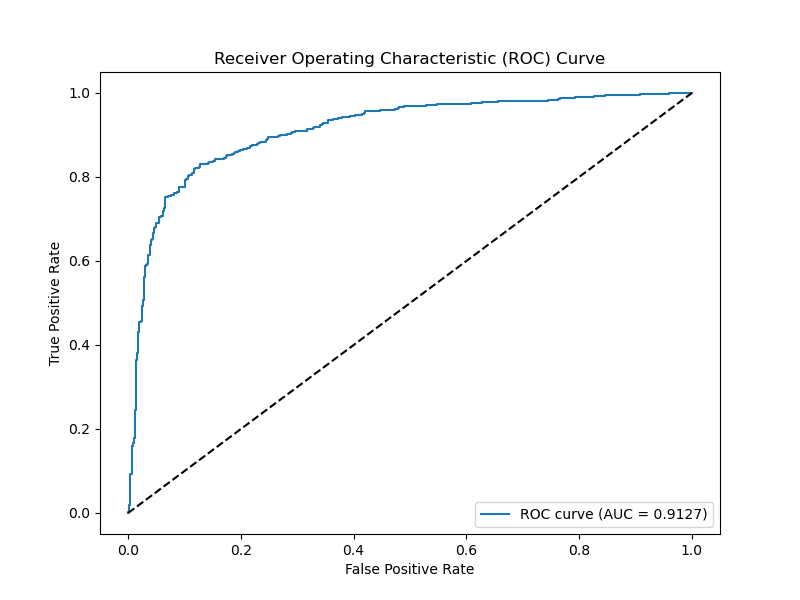

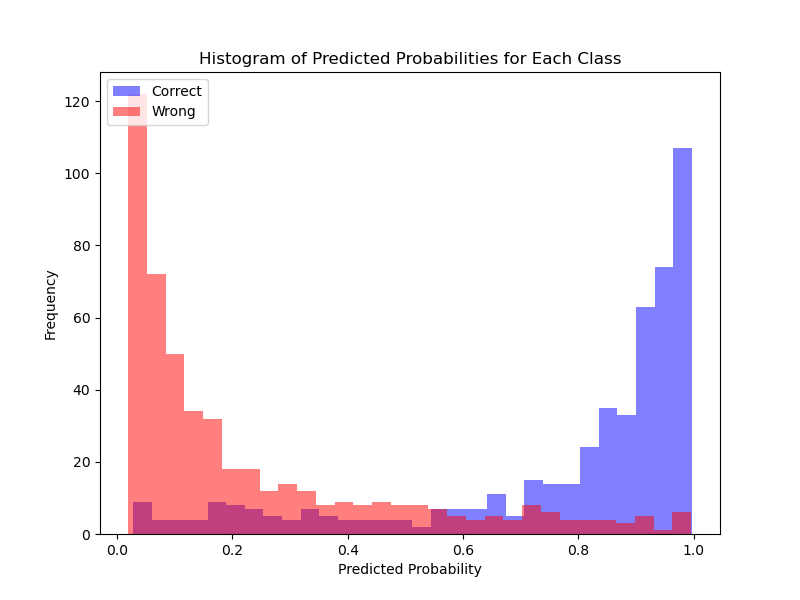

Classification Report:
               precision    recall  f1-score   support

         0.0       0.84      0.85      0.84       500
         1.0       0.85      0.84      0.84       500

    accuracy                           0.84      1000
   macro avg       0.84      0.84      0.84      1000
weighted avg       0.84      0.84      0.84      1000



In [34]:
evaluate_model(mlp_model_light, val_loader)

AUC: 0.9083


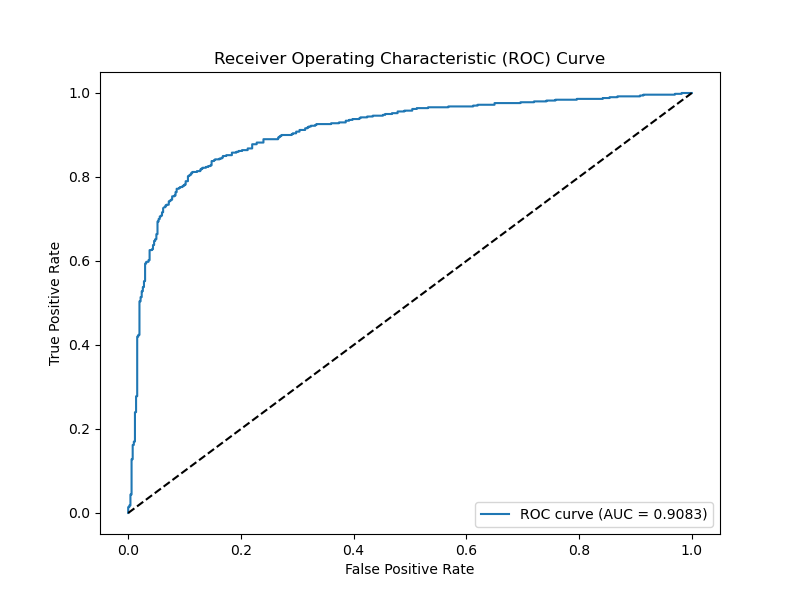

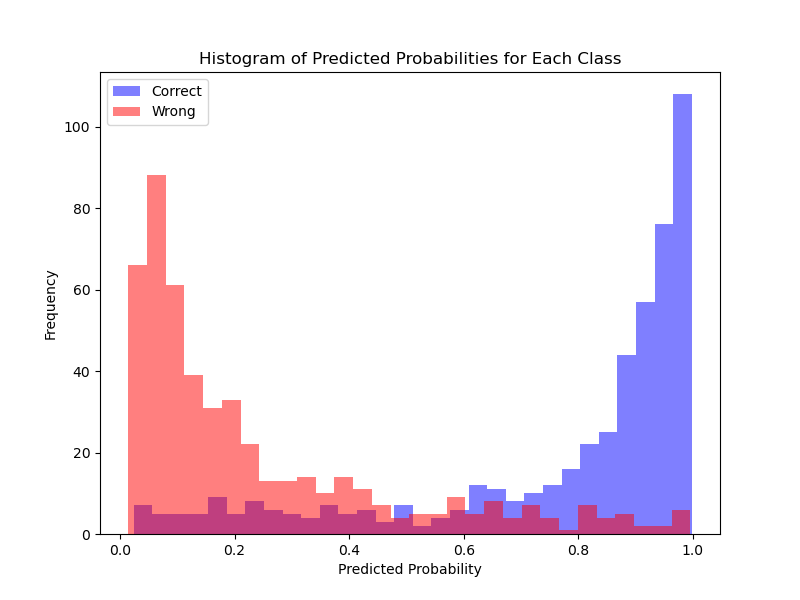

Classification Report:
               precision    recall  f1-score   support

         0.0       0.84      0.85      0.84       500
         1.0       0.85      0.83      0.84       500

    accuracy                           0.84      1000
   macro avg       0.84      0.84      0.84      1000
weighted avg       0.84      0.84      0.84      1000



In [35]:
evaluate_model(mlp_model_bn_light, val_loader)

AUC: 0.9120


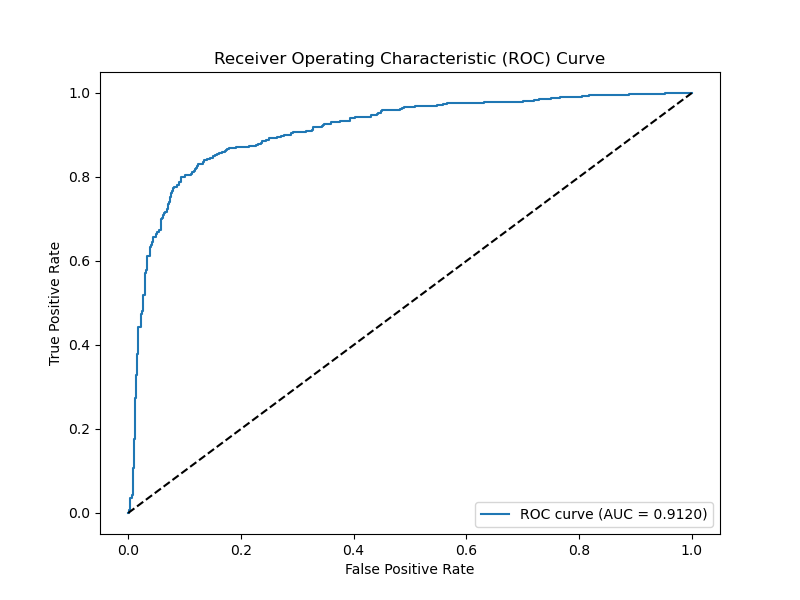

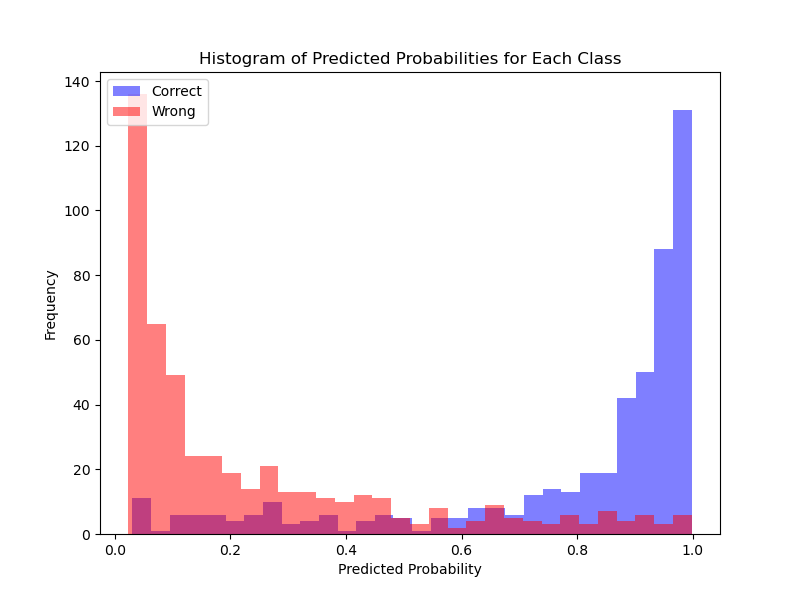

Classification Report:
               precision    recall  f1-score   support

         0.0       0.85      0.85      0.85       500
         1.0       0.85      0.85      0.85       500

    accuracy                           0.85      1000
   macro avg       0.85      0.85      0.85      1000
weighted avg       0.85      0.85      0.85      1000



In [56]:
evaluate_model(mlp_model_large, val_loader)

AUC: 0.9044


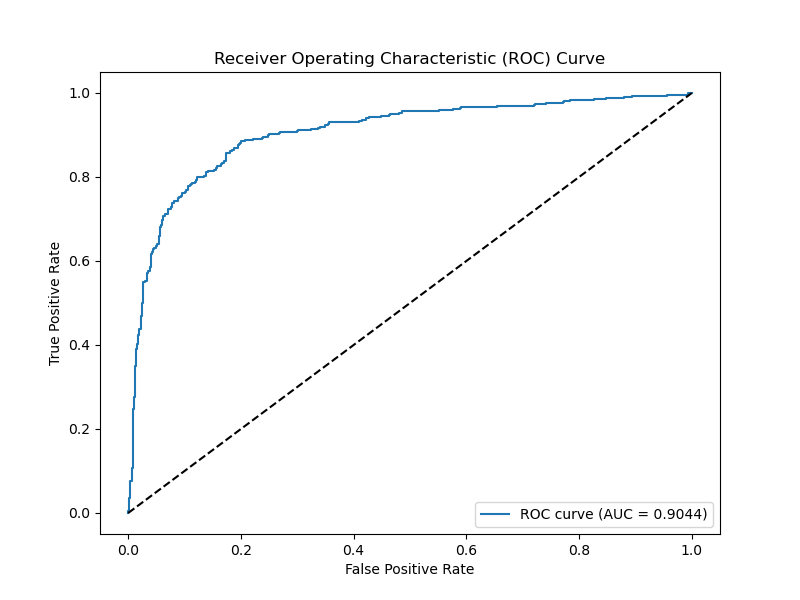

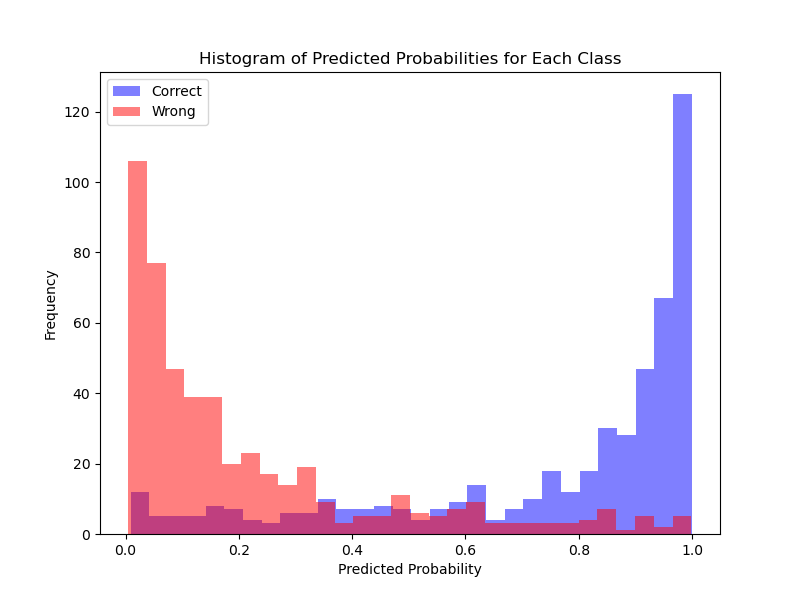

Classification Report:
               precision    recall  f1-score   support

         0.0       0.81      0.87      0.84       500
         1.0       0.86      0.80      0.83       500

    accuracy                           0.83      1000
   macro avg       0.83      0.83      0.83      1000
weighted avg       0.83      0.83      0.83      1000



In [36]:
evaluate_model(mlp_model_bn_large, val_loader)

## FIX HERE

In [92]:
# Create dataloaders WITHOUT normalization
train_loader_raw, val_loader_raw = get_conceptogram_dataloaders(
    train_dataset, y_train, val_dataset, y_val, 
    n_samples_train=1000, n_samples_val=200, batch_size=64, normalize=False, return_test_indices=False
)

# Create dataloaders WITH normalization
train_loader_norm, val_loader_norm = get_conceptogram_dataloaders(
    train_dataset, y_train, val_dataset, y_val, 
    n_samples_train=1000, n_samples_val=200, batch_size=64, normalize=True, return_test_indices=False
)
input_size = np.product(train_dataset.shape[1], train_dataset.shape[2])
# Initialize models
model_raw = MLPClassifier_Light(input_size=input_size)
model_norm = MLPClassifier_Light(input_size=input_size)

# Loss & optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer_raw = torch.optim.Adam(model_raw.parameters(), lr=0.001)
optimizer_norm = torch.optim.Adam(model_norm.parameters(), lr=0.001)

# Train models
print("\nTraining without normalization:")
val_acc_raw = train_and_evaluate(train_loader_raw, val_loader_raw, model_raw, criterion, optimizer_raw)

print("\nTraining with normalization:")
val_acc_norm = train_and_evaluate(train_loader_norm, val_loader_norm, model_norm, criterion, optimizer_norm)

# Compare performance
print(f"\nFinal Validation Accuracy (Without Normalization): {val_acc_raw:.4f}")
print(f"Final Validation Accuracy (With Normalization): {val_acc_norm:.4f}")


/tmp/ipykernel_3148241/1142400477.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.data = torch.tensor(data, dtype=torch.float32)
/tmp/ipykernel_3148241/1142400477.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(labels, dtype=torch.float32)


ValueError: Found array with dim 3. StandardScaler expected <= 2.

## Comparisons

### DNN

In [37]:
# load DNN scores 
with open(results_dir/f'full_dnn_performance_{dataset}.pkl', 'rb') as f:
    o_dnn_dfs = pickle.load(f)

out_df = o_dnn_dfs['test']

In [38]:
out_df

,max,entropy,label,true,result
0,0.998509,0.995118,3,3,True
1,0.999998,0.999989,8,8,True
2,0.730902,0.741406,8,8,True
3,0.989814,0.970400,0,0,True
4,0.999999,0.999995,6,6,True
...,...,...,...,...,...
9995,0.572633,0.683141,0,8,False
9996,0.703418,0.719525,3,3,True
9997,0.999992,0.999953,5,5,True
9998,0.999992,0.999951,1,1,True


In [39]:
# consider only the samples onto which the binary classifier was evaluated
test_indices = np.concatenate([undersampled_class_0_indices, undersampled_class_1_indices])

In [40]:
all_labels_dnn = out_df.loc[test_indices, 'result'].values
all_probs_dnn = out_df.loc[test_indices, 'max'].values

auc_score_dnn = roc_auc_score(all_labels_dnn, all_probs_dnn)
print(f'AUC: {auc_score_dnn:.4f}')

fpr_dnn, tpr_dnn, thresholds_dnn = roc_curve(all_labels_dnn, all_probs_dnn)

AUC: 0.9415


In [41]:
dnn_perf = {'labels' : all_labels_dnn, 'softmax_max': all_probs_dnn}

### Binary Classifiers

In [42]:
res_mlp_light = eval_model_binary(mlp_model_light, val_loader)

In [43]:
res_mlp_bn_light = eval_model_binary(mlp_model_bn_light, val_loader)

In [57]:
res_mlp_large = eval_model_binary(mlp_model_large, val_loader)

In [44]:
res_mlp_bn_large = eval_model_binary(mlp_model_bn_large, val_loader)

In [40]:
# save results

# dnn
# with open(results_dir/f'dnn_performance_{dataset}.pkl', 'wb') as f:
#     pickle.dump(dnn_perf, f)

# mlp models
# with open(results_dir/f'mlp_light_performance_{dataset}.pkl', 'wb') as f:
#     pickle.dump(res_mlp_bn_light, f)

### Results Visualization

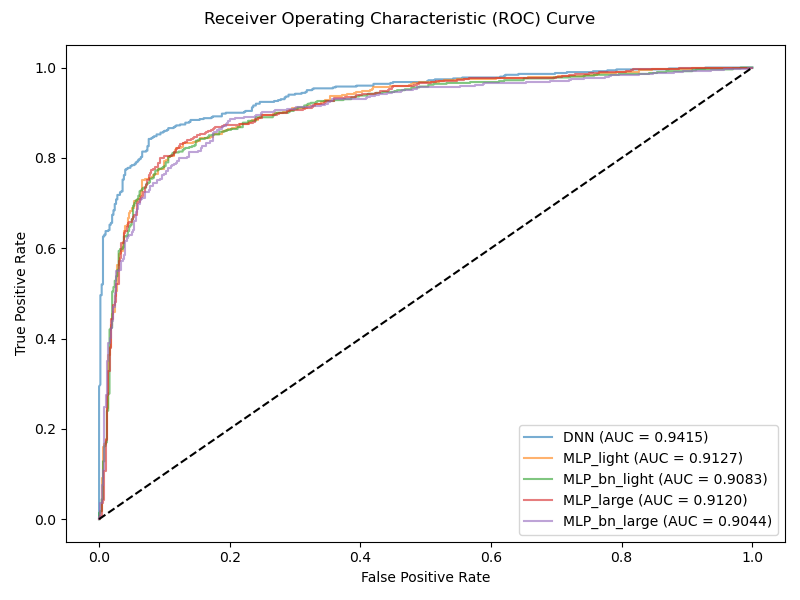

In [59]:
fig, axs = plt.subplots(figsize=(8, 6))
fig.suptitle('Receiver Operating Characteristic (ROC) Curve')

axs.plot(fpr_dnn, tpr_dnn, label=f'DNN (AUC = {auc_score_dnn:.4f})', alpha=0.6)
axs.plot(res_mlp_light['fpr'], res_mlp_light['tpr'], label=f'MLP_light (AUC = {res_mlp_light['auc_score']:.4f})', alpha=0.6)
axs.plot(res_mlp_bn_light['fpr'], res_mlp_bn_light['tpr'], label=f'MLP_bn_light (AUC = {res_mlp_bn_light['auc_score']:.4f})', alpha=0.6)
axs.plot(res_mlp_large['fpr'], res_mlp_large['tpr'], label=f'MLP_large (AUC = {res_mlp_large['auc_score']:.4f})', alpha=0.6)
axs.plot(res_mlp_bn_large['fpr'], res_mlp_bn_large['tpr'], label=f'MLP_bn_large (AUC = {res_mlp_bn_large['auc_score']:.4f})', alpha=0.6)

axs.plot([0, 1], [0, 1], 'k--')  # diagonal line (no discrimination)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend(loc='lower right')
plt.tight_layout()

In [64]:
# Example usage:
model_results = {
 'DNN': {'all_labels': all_labels_dnn, 'all_probs': all_probs_dnn},
 'MLP_light': res_mlp_light,
 'MLP_bn_light': res_mlp_bn_light,
 'MLP_large': res_mlp_large,
 'MLP_bn_large': res_mlp_bn_large
}


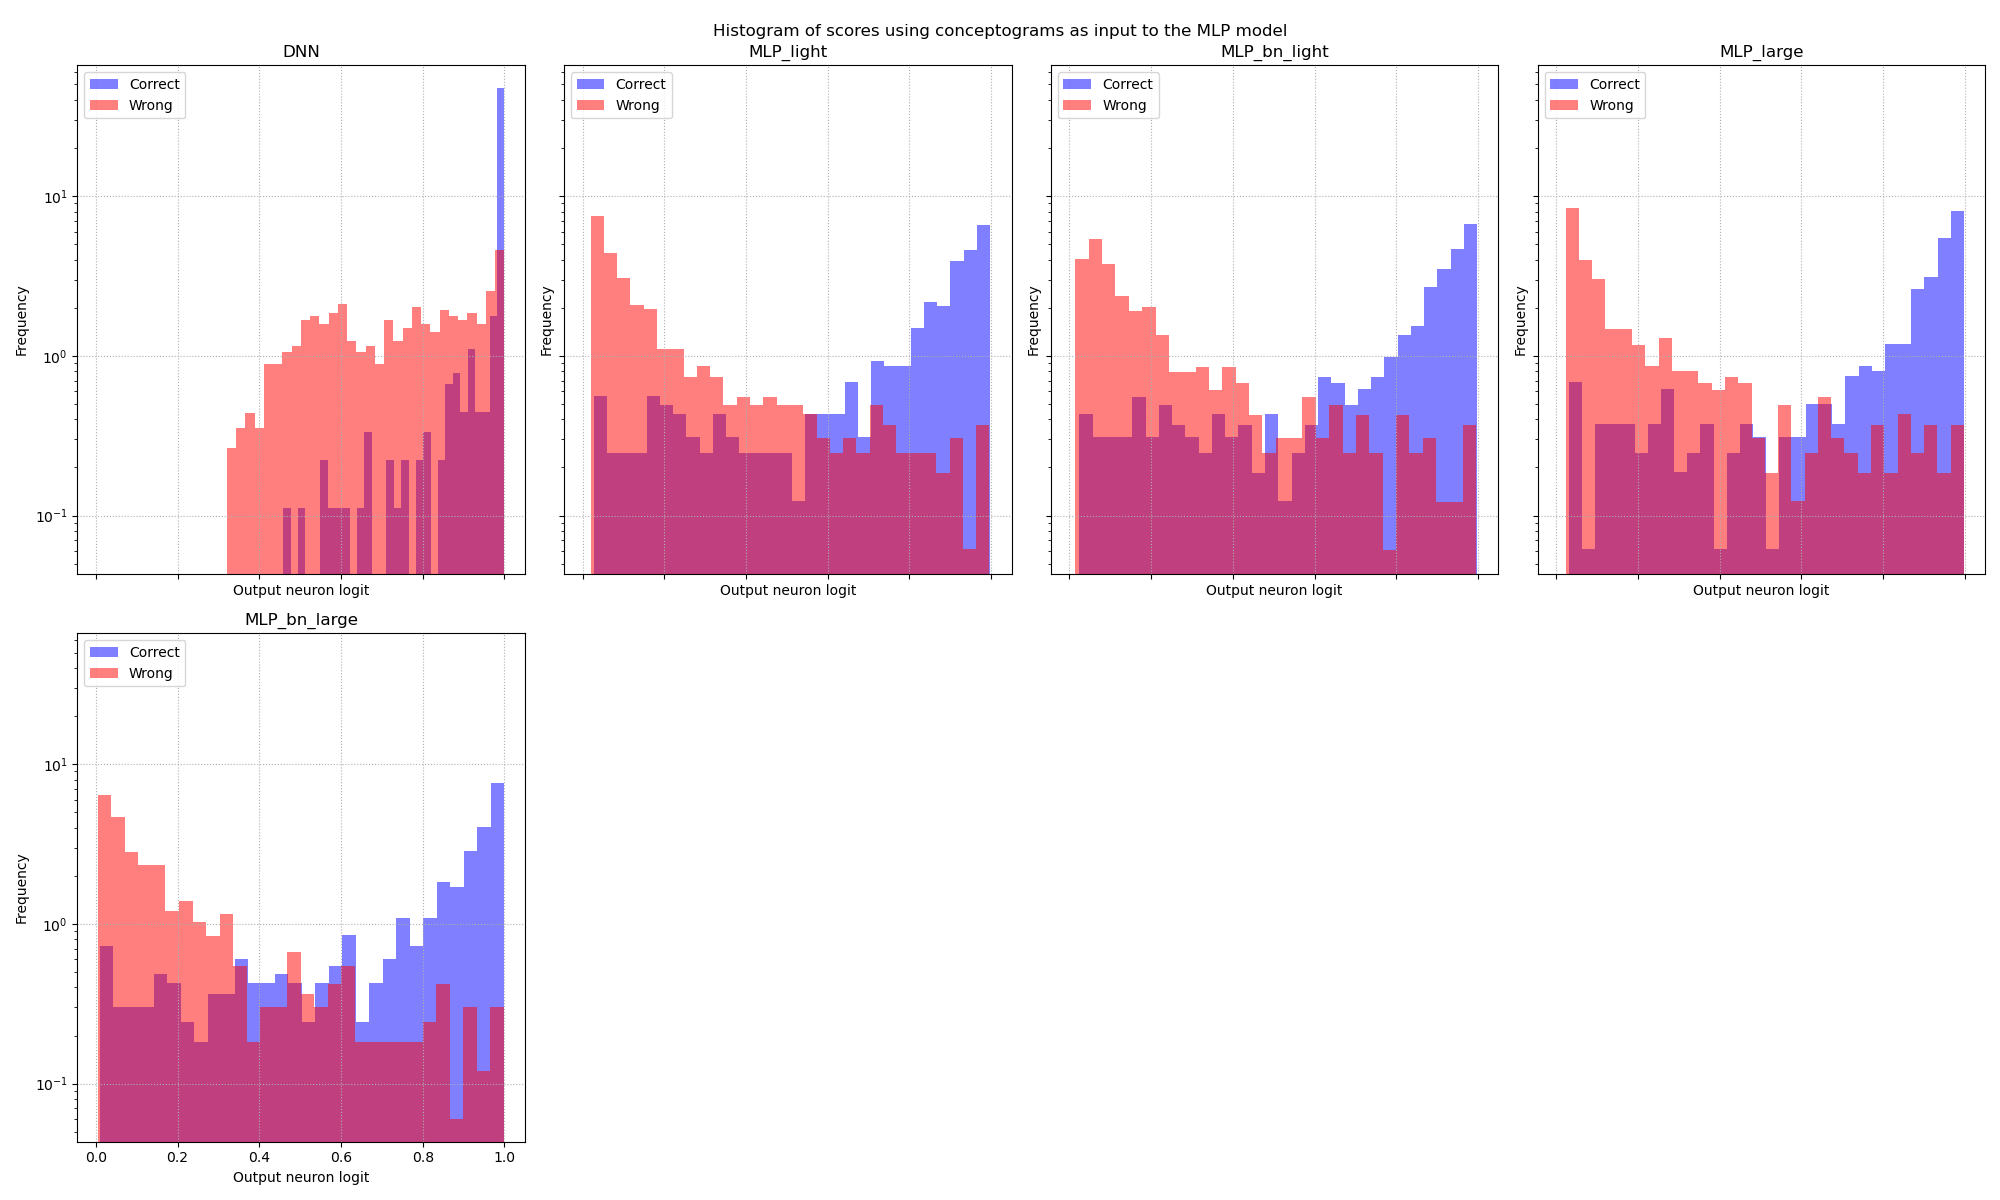

In [67]:
plot_model_histograms(model_results, ['DNN', 'MLP_light', 'MLP_bn_light', 'MLP_large', 'MLP_bn_large'])

/tmp/ipykernel_3148241/2664145446.py:71: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.text(text_x, text_y, f'KS: {float(ks_stat):.4f}\nBC: {float(bhattacharyya_dist):.4f}',


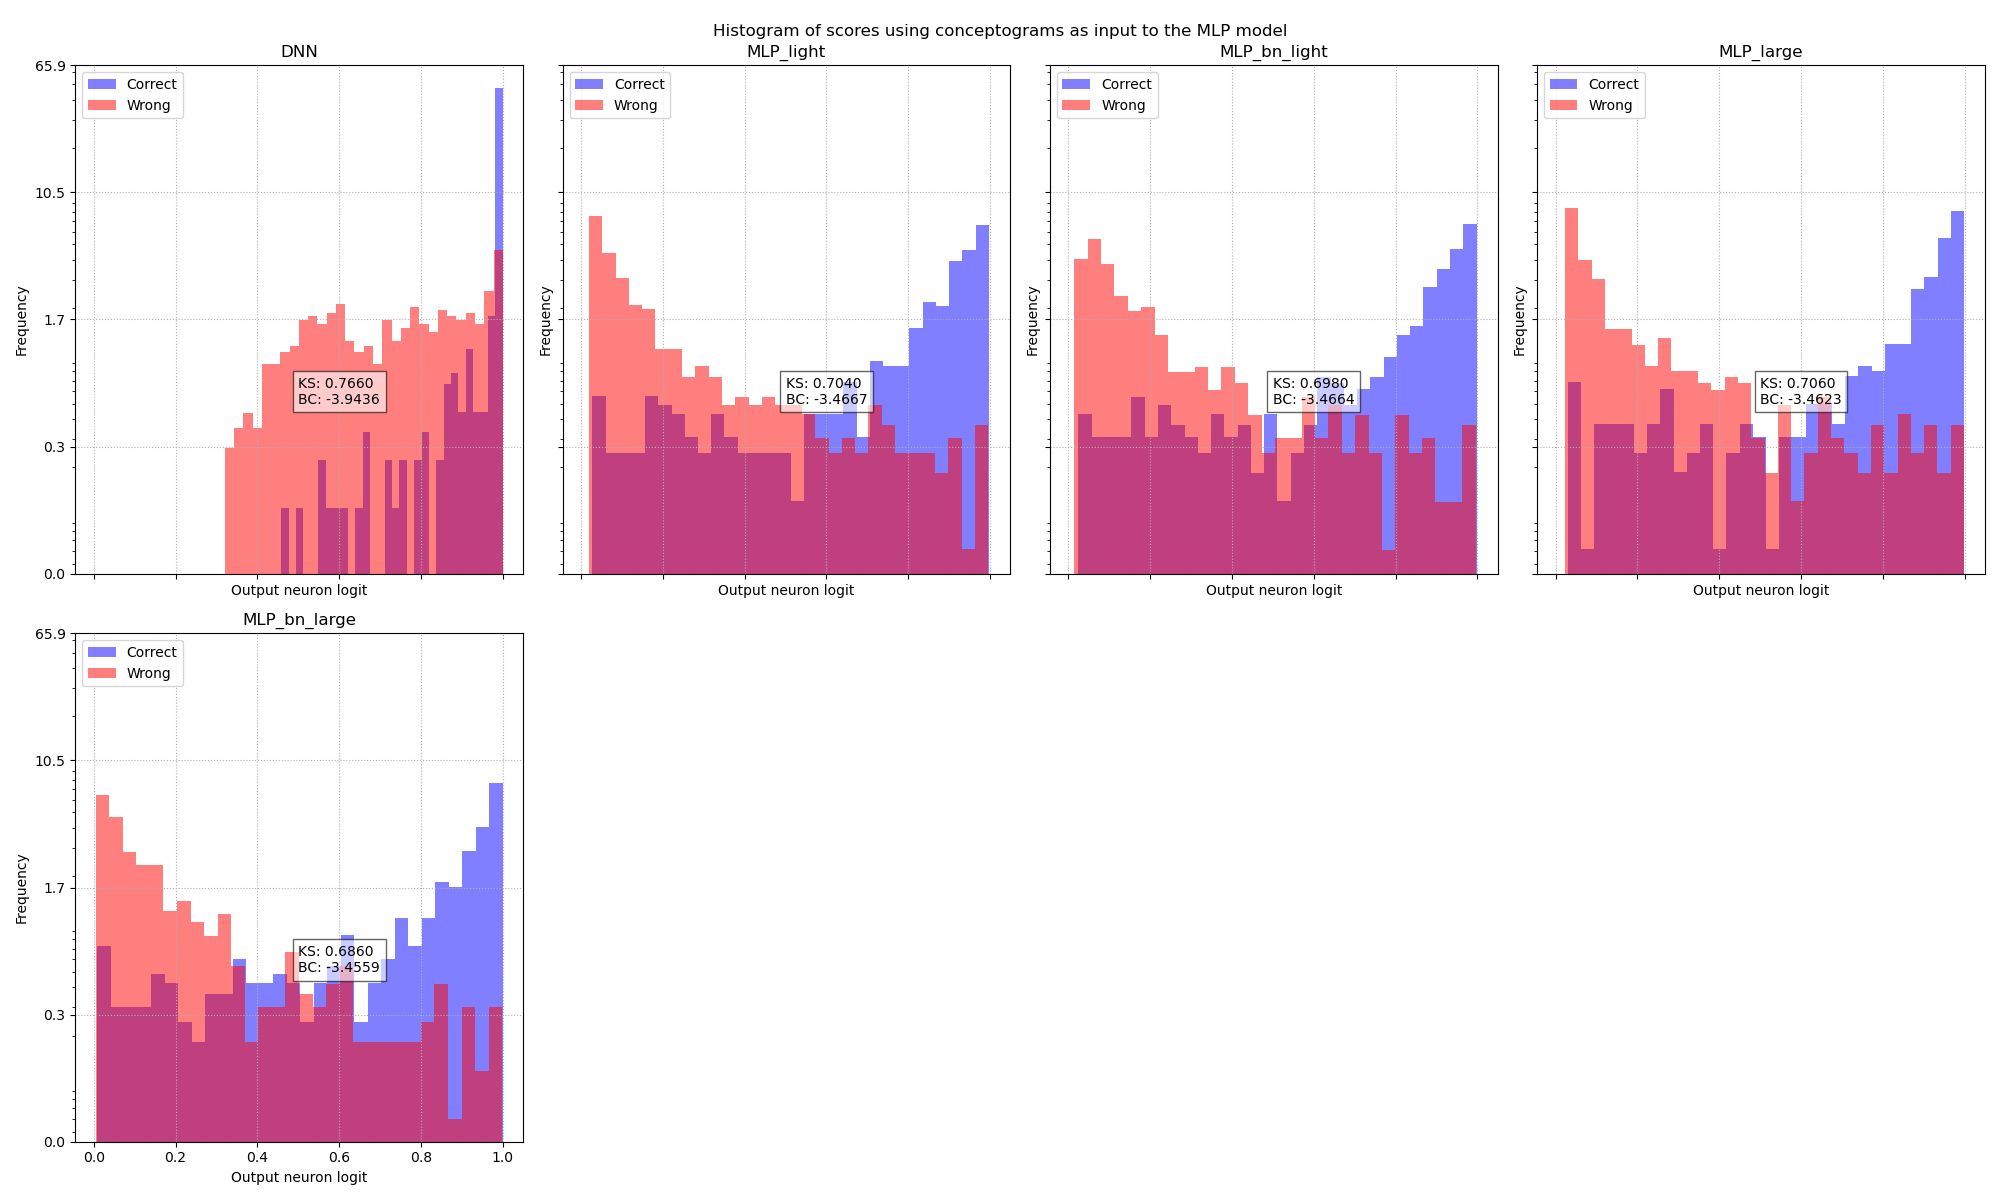

In [76]:
plot_model_histograms(model_results, ['DNN', 'MLP_light', 'MLP_bn_light', 'MLP_large', 'MLP_bn_large'])

In [49]:
# hist
# fig, axs = plt.subplots(1, 4, figsize=(15, 6), sharey=True, sharex=True)
# fig.suptitle('Histogram of scores using conceptograms as input to the MLP model')
# 
# axs[0].set_title('DNN')
# axs[0].hist(all_probs_dnn[all_labels_dnn == 1], bins=30, alpha=0.5, label='Correct', color='b', density=True, log=True) # label='Class 0 (True)', color='b')
# axs[0].hist(all_probs_dnn[all_labels_dnn == 0], bins=30, alpha=0.5, label='Wrong', color='r', density=True, log=True) # label='Class 1 (True)', color='r')
# axs[0].set_xlabel('softmax confidence')
# 
# axs[1].set_title('MLP_light')
# all_labels = res_mlp_light['all_labels']
# all_probs = res_mlp_light['all_probs']
# axs[1].hist(all_probs[all_labels == 1], bins=30, alpha=0.5, label='Correct', color='b', density=True, log=True) # label='Class 0 (True)', color='b')
# axs[1].hist(all_probs[all_labels == 0], bins=30, alpha=0.5, label='Wrong', color='r', density=True, log=True) # label='Class 1 (True)', color='r')
# axs[1].set_xlabel('output neuron logit')
# 
# axs[2].set_title('MLP_bn_light')
# all_labels = res_mlp_bn_light['all_labels']
# all_probs = res_mlp_bn_light['all_probs']
# axs[2].hist(all_probs[all_labels == 1], bins=30, alpha=0.5, label='Correct', color='b', density=True, log=True) # label='Class 0 (True)', color='b')
# axs[2].hist(all_probs[all_labels == 0], bins=30, alpha=0.5, label='Wrong', color='r', density=True, log=True) # label='Class 1 (True)', color='r')
# axs[2].set_xlabel('output neuron logit')
# 
# axs[3].set_title('MLP_bn_large')
# all_labels = res_mlp_bn_large['all_labels']
# all_probs = res_mlp_bn_large['all_probs']
# axs[3].hist(all_probs[all_labels == 1], bins=30, alpha=0.5, label='Correct', color='b', density=True, log=True) # label='Class 0 (True)', color='b')
# axs[3].hist(all_probs[all_labels == 0], bins=30, alpha=0.5, label='Wrong', color='r', density=True, log=True) # label='Class 1 (True)', color='r')
# axs[3].set_xlabel('output neuron logit')
# 
# for ax in axs:
#     ax.legend(loc='upper left')
#     ax.set_ylabel('Frequency')
# plt.tight_layout()

## Combining thresholds from DNN and binary classifier scores

In [77]:
ts_vals = np.linspace(0, 1, 50)
tp_vals = np.linspace(0, 1, 50) 

scores1 = all_probs_dnn
scores2 = res_mlp_large['all_preds'] # res_mlp_light['all_preds']
labels = all_labels_dnn

In [78]:
f1_scores, precision_scores, recall_scores, accuracy_scores, tpr_values, fpr_values = compute_metrics(scores1, scores2, labels, ts_vals, tp_vals)

/tmp/ipykernel_3148241/2396580413.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(6, 5))


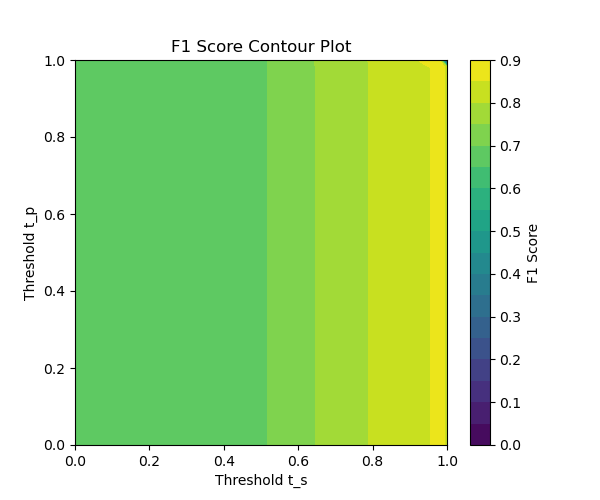

In [79]:
plot_contour(ts_vals, tp_vals, f1_scores, 'F1 Score')

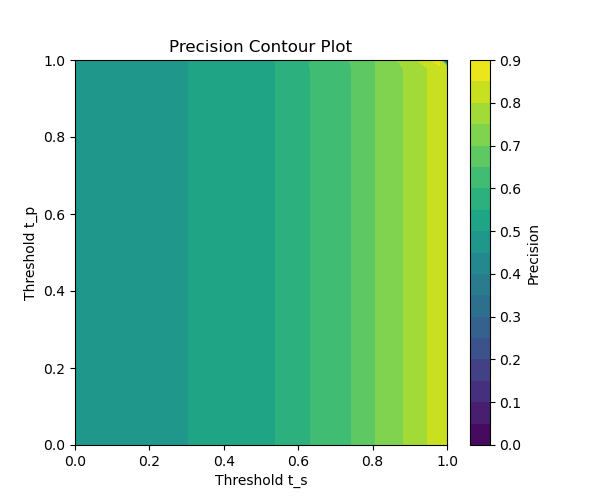

In [80]:
plot_contour(ts_vals, tp_vals, precision_scores, 'Precision')

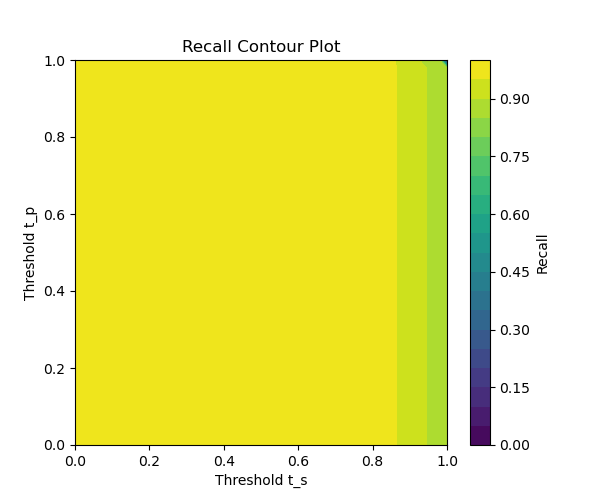

In [81]:
plot_contour(ts_vals, tp_vals, recall_scores, 'Recall')

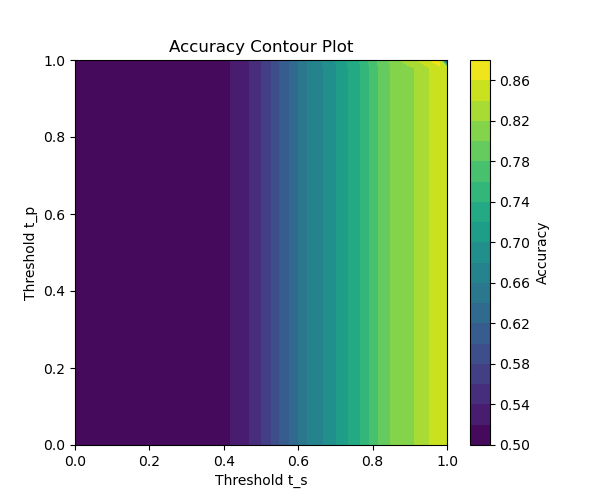

In [82]:
plot_contour(ts_vals, tp_vals, accuracy_scores, 'Accuracy')

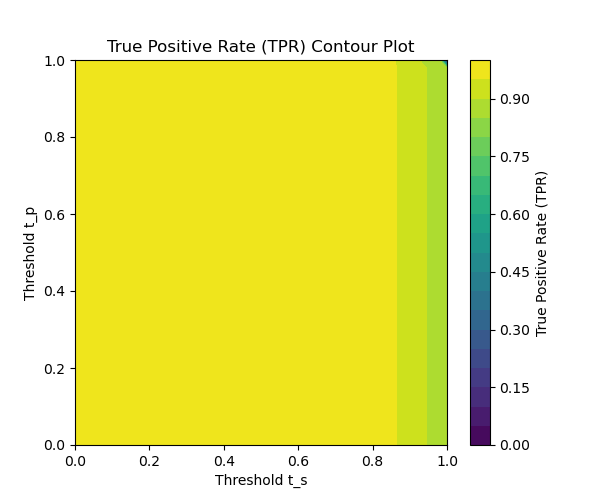

In [83]:
plot_contour(ts_vals, tp_vals, tpr_values, 'True Positive Rate (TPR)')

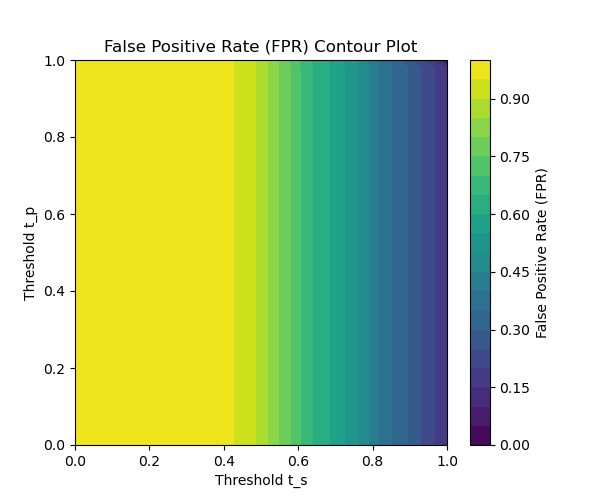

In [84]:
plot_contour(ts_vals, tp_vals, fpr_values, 'False Positive Rate (FPR)')

In [86]:
# a possible way to save csv results

df = pd.DataFrame()
df['score_dnn'] = dnn_perf['softmax_max']
df['score_mlp_large'] = res_mlp_large['all_probs']
df['labels'] = res_mlp_large['all_labels']

#df.to_csv('dnn_vs_mlp.csv', index=False)
df

,score_dnn,score_mlp_large,labels
0,0.999960,0.949843,1.0
1,1.000000,0.994577,1.0
2,0.999999,0.913871,1.0
3,0.999995,0.670216,1.0
4,0.999909,0.889948,1.0
...,...,...,...
995,0.950034,0.253474,0.0
996,0.983934,0.664076,0.0
997,0.885659,0.063063,0.0
998,0.544540,0.433423,0.0
